In [1]:
from googletrans import Translator
import pandas as pd
import numpy as np
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sns
from deep_translator import GoogleTranslator
import textstat

#pip install googletrans==3.1.0a0
#https://stackoverflow.com/questions/52455774/googletrans-stopped-working-with-error-nonetype-object-has-no-attribute-group

In [3]:
def translate(to_translate, src, dest):
    return(GoogleTranslator(source=src, target=dest).translate(to_translate))


def measure_backtranslation(to_translate, src_language, dest_language):
    forward_translation = translate(to_translate, src_language, dest_language)
    back_translation = translate(
        forward_translation, dest_language, src_language)
    distance = Levenshtein.distance(to_translate.lower(), back_translation.lower())
    return(to_translate, forward_translation, back_translation, distance)

In [4]:
ls data

en-es-sorted-en.txt     en-es.tmx               en-fr-sorted-pairs.txt
en-es-sorted-es.txt     en-fr-sorted-en.txt     en-fr.tmx
en-es-sorted-pairs.txt  en-fr-sorted-fr.txt


In [5]:
## Handling the English Sentences

In [6]:
with open('data/en-es-sorted-en.txt') as f:
    lines = f.readlines()

In [7]:
en = pd.DataFrame(data = {'Phrase':lines})

In [8]:
en['Phrase'] = en['Phrase'].str[:-1]

In [9]:
en['PhraseLength'] = en.apply(lambda row: len(row['Phrase']), axis = 1)

In [10]:
def word_count(row):
    return(len(row['Phrase'].split()))

In [11]:
en['WordCount'] = en.apply(lambda row: word_count(row), axis = 1)

In [12]:
en_sub = en[(en['WordCount'] >= 3) & (en['WordCount'] <= 20)]

In [13]:
def alphanumeric_percent(row):
    letters = len([x for x in row['Phrase'] if x.isalpha()])
    return(letters/len(row['Phrase'].replace(' ','')))

In [14]:
en_sub['AlphaNumeric%'] = en_sub.apply(lambda row: alphanumeric_percent(row), axis = 1)

/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
sub2 = en_sub[en_sub['AlphaNumeric%'] > 0.975]

In [24]:
to_translates = []
forward_translations = []
back_translations = []
distances = []
counter = 0

In [25]:
sub3 = sub2.iloc[:10000]

In [26]:
for idx, row in sub3[counter:].iterrows():
    if counter % 1000 == 0:
        print(counter)
    a,b,c,d = measure_backtranslation(row['Phrase'], 'en', 'chinese (simplified)')
    to_translates.append(a)
    forward_translations.append(b)
    back_translations.append(c)
    distances.append(d)
    counter += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [30]:
sub3['ForwardTranslation'] = forward_translations
sub3['BackTranslation'] = back_translations
sub3['EditDistance'] = distances

/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [31]:
sub3.to_csv('EnglishChinese(Simplified)BacktranslationResults.csv')

In [32]:
sub3.head()

,Phrase,PhraseLength,WordCount,AlphaNumeric%,ForwardTranslation,BackTranslation,EditDistance
22593,The MIT Press,13,3,1.0,麻省理工学院出版社,MIT Press,4
26410,The Cerro Torre,15,3,1.0,塞罗托雷,Cerrotore,6
30208,at Rolling Stone,16,3,1.0,在滚石,At the rolling stone,4
32718,at the DCU Guide,16,4,1.0,在DCU指南上,On the DCU guide,2
33936,The Movie Archive,17,3,1.0,电影档案馆,Film Archive,8


In [33]:
sub3['EditDistance%'] = sub3['EditDistance']/sub3['PhraseLength']

/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='WordCount', ylabel='EditDistance%'>

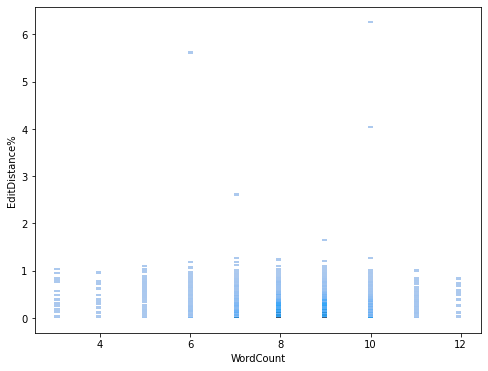

In [34]:
fig, ax = plt.subplots(figsize = (8,6))
sns.histplot(x = sub3['WordCount'], y = sub3['EditDistance%'])

In [35]:
sub3['Readability'] = sub3.apply(lambda row: textstat.flesch_reading_ease(row['Phrase']), axis = 1)
#The table is an example of values. While the maximum score is 121.22, there is no limit on how low
#the score can be. A negative score is valid. Higher score = easier to read
sub3['GradeLevel'] = sub3.apply(lambda row: textstat.flesch_kincaid_grade(row['Phrase']), axis = 1)
#Returns the Flesch-Kincaid Grade of the given text. This is a grade formula in that a score of 9.3
#means that a ninth grader would be able to read the document.

/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
sub3.groupby(['WordCount'], as_index = False).agg({'Phrase':'count', 'PhraseLength':'mean',
                                                   'EditDistance':'mean', 'EditDistance%':'mean',
                                                   'Readability':'mean', 'GradeLevel':'mean'})

,WordCount,Phrase,PhraseLength,EditDistance,EditDistance%,Readability,GradeLevel
0,3,30,20.833333,5.366667,0.270371,43.330333,7.943333
1,4,27,36.185185,16.370370,0.391041,25.742593,10.662963
2,5,110,44.000000,17.190909,0.382535,6.568364,13.575455
3,6,472,47.836864,14.489407,0.302317,18.752839,12.149364
4,7,1592,48.797111,13.270101,0.271957,43.844209,8.884108
5,8,3019,49.656840,12.825770,0.258126,61.115260,6.730010
6,9,2967,50.322548,13.305022,0.264373,76.624894,4.810347
7,10,1475,50.934915,14.099661,0.276772,85.187756,3.876136
8,11,285,51.442105,14.673684,0.285261,91.845368,3.184211
9,12,23,52.000000,17.521739,0.336957,100.128696,2.291304


Text(0.5, 1.0, 'Phrase Grade Level vs. Edit Distance as % of Phrase Length')

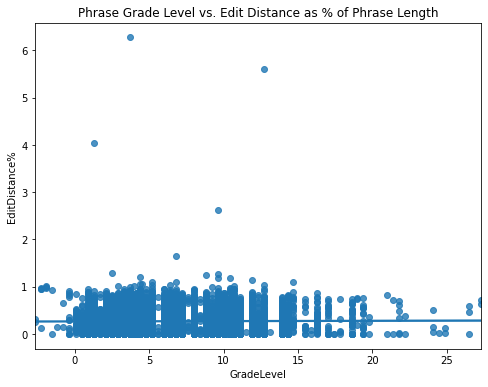

In [37]:
fig, ax = plt.subplots(figsize = (8,6))
sns.regplot(x = sub3['GradeLevel'], y = sub3['EditDistance%'])
plt.title('Phrase Grade Level vs. Edit Distance as % of Phrase Length')

Text(0.5, 1.0, 'Phrase Readability vs. Edit Distance as % of Phrase Length')

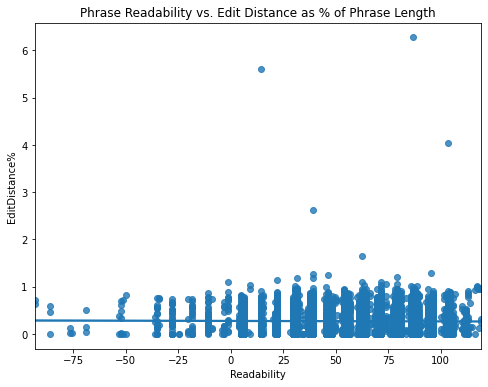

In [38]:
fig, ax = plt.subplots(figsize = (8,6))
sns.regplot(x = sub3['Readability'], y = sub3['EditDistance%'])
plt.title('Phrase Readability vs. Edit Distance as % of Phrase Length')

In [39]:
sub3['ReadabilityBucket'] = np.where(sub3['Readability'] < 0, '< 0',
                            np.where(sub3['Readability'] < 20, '0 - 20',
                            np.where(sub3['Readability'] < 40, '20 - 40',
                            np.where(sub3['Readability'] < 60, '40 - 60',
                            np.where(sub3['Readability'] < 80, '60 - 80',
                            np.where(sub3['Readability'] < 100, '80 - 100', '100+'))))))

/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
sub3.groupby(['ReadabilityBucket'], as_index = False).agg({'Phrase':'count','WordCount':'mean',
                                                           'PhraseLength':'mean', 'GradeLevel':'mean',
                                                           'EditDistance':'mean', 'EditDistance%':'mean'})

,ReadabilityBucket,Phrase,WordCount,PhraseLength,GradeLevel,EditDistance,EditDistance%
0,0 - 20,294,6.180272,48.214286,13.487755,14.353741,0.300504
1,100+,422,9.637441,49.966825,0.969431,15.281991,0.305345
2,20 - 40,1457,7.269732,49.208648,10.420728,13.295127,0.269768
3,40 - 60,1425,7.915789,49.430877,8.197333,12.778246,0.258577
4,60 - 80,3646,8.647559,49.984366,5.617883,13.337630,0.266831
5,80 - 100,2576,9.104037,49.980978,3.190023,13.371506,0.267332
6,< 0,180,5.572222,47.344444,17.923333,15.083333,0.317347


In [41]:
sub3['EditDistance%'].mean()

0.2697362429335336

In [42]:
sub3['EditDistance%'].std()

0.2400423931051784

In [45]:
sub3['NoError'] = np.where(sub3['EditDistance'] == 0, 1, 0)
sub3['NoError'].sum()

/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1236

In [50]:
perfects = sub3[sub3['NoError'] == 1]
imperfects = sub3[sub3['NoError'] == 0]

In [47]:
perfects['WordCount'].mean()

8.233009708737864

In [48]:
perfects['Readability'].mean()

62.908608414239474

In [49]:
perfects['GradeLevel'].mean()

6.5368122977346275

In [52]:
imperfects['WordCount'].mean()

8.393884071200365

In [53]:
imperfects['Readability'].mean()

64.99288224554998

In [54]:
imperfects['GradeLevel'].mean()

6.285451848471017

In [55]:
sub3['worst_20'] = np.where(sub3['EditDistance%'] >= np.percentile(sub3['EditDistance%'],80), 1, 0)
worst_20 = sub3[sub3['worst_20'] == 1]

/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
len(worst_20)

1985

In [58]:
worst_20['WordCount'].mean()

8.272040302267003

In [59]:
worst_20['Readability'].mean()

63.36846347607053

In [60]:
worst_20['GradeLevel'].mean()

6.480453400503778

In [61]:
perfect_idxs = pd.DataFrame(data = {'idx':list(perfects.index)})
perfect_idxs.to_csv('ChinesePerfectIdxs.csv')

In [62]:
def words_preserved(row):
    preserved = []
    for word in row['Phrase'].split(' '):
        if word in row['BackTranslation']:
            preserved.append(word)
    return(preserved)

In [63]:
sub3['WordPreserved'] = sub3.apply(lambda row: words_preserved(row), axis = 1)
sub3['NumWordsPreserved'] = sub3['WordPreserved'].str.len()
sub3['PreservedWord%'] = sub3['NumWordsPreserved']/sub3['WordCount']

/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nicholas/anaconda/envs/Backtranslation/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [64]:
sub3['PreservedWord%'].mean()

0.7280181818181818